# Houses and Empty Lots for Sale in New Brunswick (as of June 12, 2020)

In this project, I scraped data from this [website](https://www.point2homes.com/CA/Real-Estate-Listings/NB.html) which lists houses and 
empty lots for sale. The selling price is listed along with the lot size. For houses, the number of bedrooms, bathrooms, the house size the house type are also given.

## 4. Exploratory Data Analysis

In [1]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
from tqdm.notebook import tqdm

train = pd.read_csv('train_cleaned.csv')
val = pd.read_csv('val_cleaned.csv')

# look at first 5 rows of training set
train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Price,Postal
0,4.0,2.0,1584.0,0.724,Family,169900,E2
1,4.0,2.0,1675.0,1.170,Residential,259000,E5
2,0.0,0.0,0.0,2.220,Empty Land,19000,E1
3,4.0,2.0,1780.0,0.134,Residential,104200,E1
4,4.0,3.0,1584.0,0.724,Residential,269000,E3


In [2]:
# Typically, price is in thousands, might as well divide these.
train['Price (x1000)'] = train['Price']/1000

# drop train['Price']
train.drop('Price',axis=1,inplace=True)

train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Postal,Price (x1000)
0,4.0,2.0,1584.0,0.724,Family,E2,169.9
1,4.0,2.0,1675.0,1.170,Residential,E5,259.0
2,0.0,0.0,0.0,2.220,Empty Land,E1,19.0
3,4.0,2.0,1780.0,0.134,Residential,E1,104.2
4,4.0,3.0,1584.0,0.724,Residential,E3,269.0


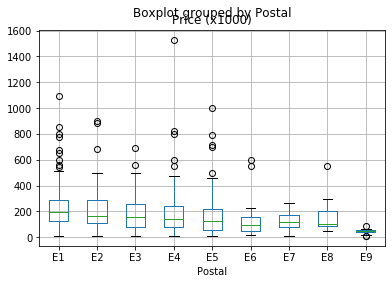

In [3]:
# plot postal vs price
train.boxplot(column='Price (x1000)',by='Postal')

Seems like there are two extreme outliers (price > $1000000). Let's check these.

In [4]:
train[train['Price (x1000)'] >= 1000]

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Postal,Price (x1000)
249,3.0,2.0,1584.0,697.000,Residential,E4,1530.0
496,5.0,4.0,5880.0,0.485,Residential,E1,1090.0


House 249 has a big lot (697 acres), and house 496 has a lot of rooms (9) and a big house (5880 sqft). So it is reasonable to keep these outliers.

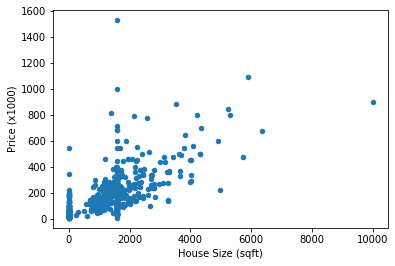

In [5]:
# plot house size vs price
train.plot.scatter(x='House Size (sqft)',y='Price (x1000)')

Okay, so house size seems to be correlated with price. So no problem there. Let's check lot size.

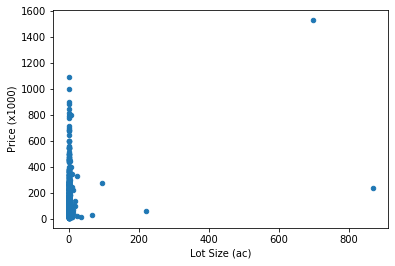

In [6]:
train.plot.scatter(x='Lot Size (ac)',y='Price (x1000)')

It makes sense that the bigger the lot size, the bigger the price. However, there is **a lot** of variability on price for small lot sizes. My guess is that a presence of the house and the total number of rooms in the lot influences the price, so an interaction term (Lot Size + House Size + Rooms) might be useful. We are adding the terms instead of multiplying them so as not to discriminate entries of empty lands (rooms = 0, house size = 0).

In [7]:
# create a feature named Rooms, where Rooms = Beds + Baths
train['Rooms'] = train['Beds'] + train['Baths']

# might need to convert house size to acres to be consistent
train['House Size (ac)'] = train['House Size (sqft)'] * (2.296 * 10**(-5))

# create a feature named Rating, where Rating = House size + Lot size + Rooms
train['Rating'] = (train['Lot Size (ac)'] + train['House Size (ac)']) * train['Rooms']

train.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Postal,Price (x1000),Rooms,House Size (ac),Rating
0,4.0,2.0,1584.0,0.724,Family,E2,169.9,6.0,0.036369,4.562212
1,4.0,2.0,1675.0,1.170,Residential,E5,259.0,6.0,0.038458,7.250748
2,0.0,0.0,0.0,2.220,Empty Land,E1,19.0,0.0,0.000000,0.000000
3,4.0,2.0,1780.0,0.134,Residential,E1,104.2,6.0,0.040869,1.049213
4,4.0,3.0,1584.0,0.724,Residential,E3,269.0,7.0,0.036369,5.322580


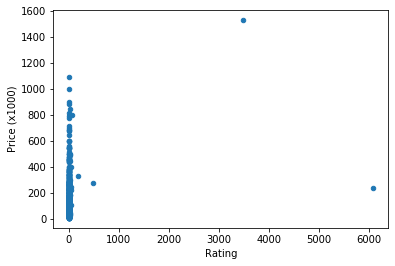

In [8]:
train.plot.scatter(x='Rating',y='Price (x1000)')

In [9]:
# drop House Size (sqft)
train.drop('House Size (sqft)',axis=1, inplace=True)

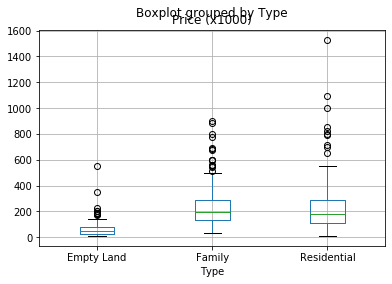

In [10]:
# Check types
train.boxplot(column='Price (x1000)', by='Type')

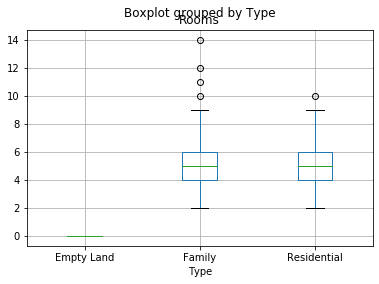

In [11]:
# now lets check the number of rooms
train.boxplot(column='Rooms', by='Type')

So houses of type Family and type Residential have **similar distributions** on Price and the number of Rooms. We might as well merge them.

In [12]:
train.replace('Family', 'Residential',inplace=True)
train.head(5)

,Beds,Baths,Lot Size (ac),Type,Postal,Price (x1000),Rooms,House Size (ac),Rating
0,4.0,2.0,0.724,Residential,E2,169.9,6.0,0.036369,4.562212
1,4.0,2.0,1.170,Residential,E5,259.0,6.0,0.038458,7.250748
2,0.0,0.0,2.220,Empty Land,E1,19.0,0.0,0.000000,0.000000
3,4.0,2.0,0.134,Residential,E1,104.2,6.0,0.040869,1.049213
4,4.0,3.0,0.724,Residential,E3,269.0,7.0,0.036369,5.322580


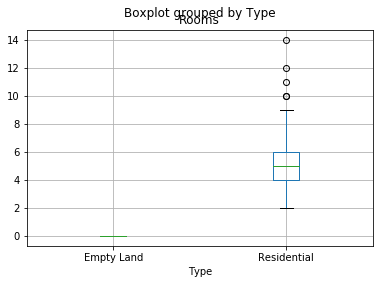

In [13]:
train.boxplot(column='Rooms', by='Type')

Now we check correlations.

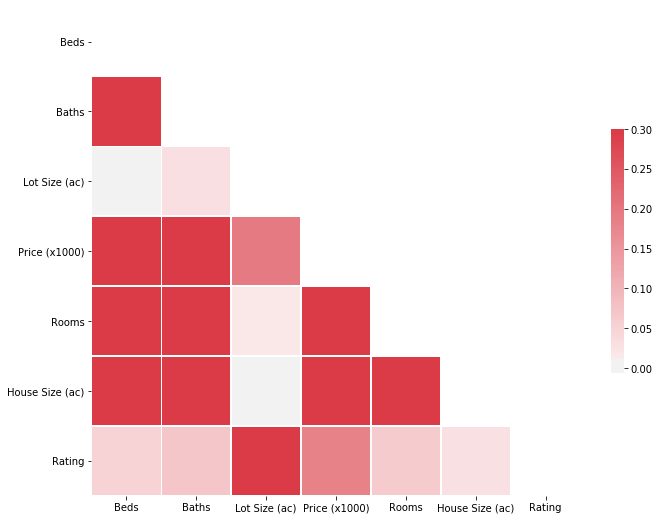

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Price is **highly correlated** with House Size, Rooms, Beds and Baths. Not so much with Lot Size. Also rooms, beds, baths and house size are highly correlated, which makes sense, and rating is highly correlated with lot size. Later on, we could probably drop somethings if

In [15]:
# Convert price to thousands
val['Price (x1000)'] = val['Price']/1000
val.drop('Price',axis=1,inplace=True)

# create a feature named Rooms, where Rooms = Beds + Baths
val['Rooms'] = val['Beds'] + val['Baths']
# might need to convert house size to acres to be consistent
val['House Size (ac)'] = val['House Size (sqft)'] * (2.296 * 10**(-5))
# create a feature named Rating, where Rating = (House size + Lot size) * Rooms
val['Rating'] = (val['Lot Size (ac)'] + val['House Size (ac)']) * val['Rooms']

val.replace('Family', 'Residential',inplace=True)
val.head(5)

,Beds,Baths,House Size (sqft),Lot Size (ac),Type,Postal,Price (x1000),Rooms,House Size (ac),Rating
0,0.0,0.0,0.0,1.30,Empty Land,E1,39.9,0.0,0.000000,0.000000
1,3.0,2.0,1519.0,10.00,Residential,E5,70.0,5.0,0.034876,50.174381
2,0.0,0.0,0.0,1.03,Empty Land,E9,8.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,1.30,Empty Land,E4,24.9,0.0,0.000000,0.000000
4,3.0,1.0,1725.0,1.00,Residential,E2,119.9,4.0,0.039606,4.158424


## 5. Modelling

We will be using XGBoost to predict house and land prices. To assess how our model performs, we will be using the Root Mean Squared Error between the logarithm of the predicted price and the logarithm of the actual price. This would imply that the effect on predicting cheap and expensive houses would be [equal](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). 

In [16]:
train.loc[:,train.columns != 'Price (x1000)']

,Beds,Baths,Lot Size (ac),Type,Postal,Rooms,House Size (ac),Rating
0,4.0,2.0,0.724,Residential,E2,6.0,0.036369,4.562212
1,4.0,2.0,1.170,Residential,E5,6.0,0.038458,7.250748
2,0.0,0.0,2.220,Empty Land,E1,0.0,0.000000,0.000000
3,4.0,2.0,0.134,Residential,E1,6.0,0.040869,1.049213
4,4.0,3.0,0.724,Residential,E3,7.0,0.036369,5.322580
...,...,...,...,...,...,...,...,...
532,0.0,0.0,2.220,Empty Land,E5,0.0,0.000000,0.000000
533,4.0,3.0,0.090,Residential,E1,7.0,0.036369,0.884580
534,2.0,2.0,5.000,Residential,E3,4.0,0.041328,20.165312
535,3.0,2.0,0.294,Residential,E5,5.0,0.040823,1.674114


In [17]:
import xgboost as xgb
from sklearn.metrics import make_scorer

def RMSE(y_true, y_pred, **kwargs):
    return np.sqrt(np.mean((np.log(y_true)-np.log(y_pred))**2))

my_scorer = make_scorer(RMSE, greater_is_better=False)

# perform one-hot encoding on type and postal
from sklearn.preprocessing import OneHotEncoder

y_train = train['Price (x1000)']
X_train = train.drop('Price (x1000)',axis=1)

val.drop('House Size (sqft)', axis=1, inplace=True)
y_val = val['Price (x1000)']
X_val = val.drop('Price (x1000)', axis=1)

In [18]:
cat_features = ['Type', 'Postal']
OneHot = OneHotEncoder(handle_unknown='ignore',sparse=False)
cat_train = pd.DataFrame(OneHot.fit_transform(X_train[cat_features]))
cat_train.columns = OneHot.get_feature_names(['Type','Postal'])

cat_train.index = X_train.index

noncat_X_train = X_train.drop(cat_features, axis = 1)

OneHot_X_train = pd.concat([noncat_X_train, cat_train], axis = 1)
feat_labels = OneHot_X_train.columns
OneHot_X_train

,Beds,Baths,Lot Size (ac),Rooms,House Size (ac),Rating,Type_Empty Land,Type_Residential,Postal_E1,Postal_E2,Postal_E3,Postal_E4,Postal_E5,Postal_E6,Postal_E7,Postal_E8,Postal_E9
0,4.0,2.0,0.724,6.0,0.036369,4.562212,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,1.170,6.0,0.038458,7.250748,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.220,0.0,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2.0,0.134,6.0,0.040869,1.049213,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.724,7.0,0.036369,5.322580,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,0.0,0.0,2.220,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
533,4.0,3.0,0.090,7.0,0.036369,0.884580,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
534,2.0,2.0,5.000,4.0,0.041328,20.165312,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
535,3.0,2.0,0.294,5.0,0.040823,1.674114,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
data_dmatrix = xgb.DMatrix(data=OneHot_X_train, label=y_train)

RMSE_train = 0.4991664716749483


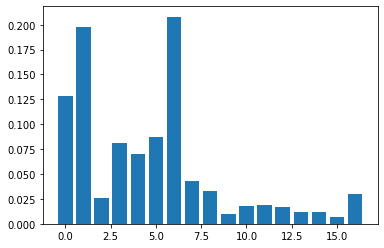

In [20]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.25, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

xg_reg.fit(OneHot_X_train, np.sqrt(y_train))

y_train_pred = xg_reg.predict(OneHot_X_train)

RMSE_train = np.sqrt(np.mean((np.log(y_train)-np.log(y_train_pred**2))**2))
print('RMSE_train = {}'.format(RMSE_train))

# plot
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
plt.show()

If we ignore importances less than 5%, it turns out that the important features are Beds, Baths, Rooms, House Size, Rating and checking whether its Empty Land. Checking whether its residential is no longer needed as there are only two types. Lets ignore the other features then.

In [21]:
cat_val = pd.DataFrame(OneHot.fit_transform(X_val[cat_features]))
cat_val.columns = OneHot.get_feature_names(['Type','Postal'])

cat_val.index = X_val.index

noncat_X_val = X_val.drop(cat_features, axis = 1)

OneHot_X_val = pd.concat([noncat_X_val, cat_val], axis = 1)
feat_labels = OneHot_X_val.columns
OneHot_X_val

,Beds,Baths,Lot Size (ac),Rooms,House Size (ac),Rating,Type_Empty Land,Type_Residential,Postal_E1,Postal_E2,Postal_E3,Postal_E4,Postal_E5,Postal_E6,Postal_E7,Postal_E8,Postal_E9
0,0.0,0.0,1.300,0.0,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,2.0,10.000,5.0,0.034876,50.174381,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.030,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.300,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,1.000,4.0,0.039606,4.158424,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,4.0,1.0,1.000,5.0,0.022960,5.114800,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
91,5.0,2.0,0.419,7.0,0.082541,3.510788,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,1.300,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
93,4.0,2.0,1.000,6.0,0.034876,6.209257,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now we check the RMSE for the testing set.

In [22]:
y_val_pred = xg_reg.predict(OneHot_X_val)
RMSE_val = np.sqrt(np.mean((np.log(y_val)-np.log(y_val_pred**2))**2))
print('RMSE_val = {}'.format(RMSE_val))

RMSE_val = 0.6462359920820677


## 6. Conclusion

If the model performs well, its RMSE for both training and test sets should be comparable. Since RMSE_train = 0.6035 and RMSE_val = 0.7225, the model performs poorly on the test set. I could think of a few reasons:

    1. The data is incomplete. Perhaps we can investigate further, say check the materials used to build the house (wood? concrete? ...). Is the property near a body of water? The website does not provide enough info, perhaps more web scraping is needed.
    2. The data may just be bad. There is nothing we can do if the data is bad.
    
 However, the model is not too bad, since RMSE_val is close to RMSE_train. Let's plot the residuals for the testing set.

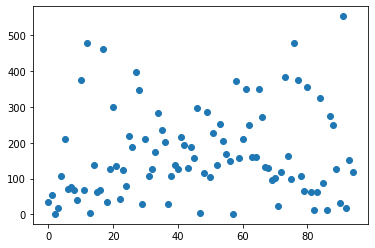

In [23]:
index = list(range(0,len(y_val)))
plt.scatter(x=index, y=abs(y_val-y_val_pred))

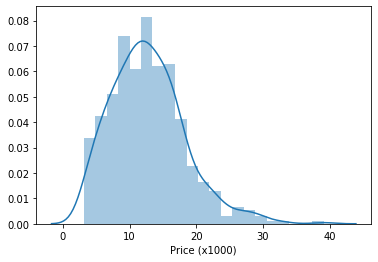

In [24]:
sns.distplot(np.sqrt(y_train))

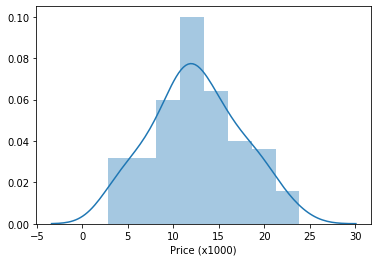

In [25]:
sns.distplot(np.sqrt(y_val))

In [ ]:
So there are 